Using device: cpu
      Model  Year         Region  Color Fuel_Type Transmission  Engine_Size_L  \
0  5 Series  2016           Asia    Red    Petrol       Manual            3.5   
1        i8  2013  North America    Red    Hybrid    Automatic            1.6   
2  5 Series  2022  North America   Blue    Petrol    Automatic            4.5   
3        X3  2024    Middle East   Blue    Petrol    Automatic            1.7   
4  7 Series  2020  South America  Black    Diesel       Manual            2.1   

   Mileage_KM  Price_USD  Sales_Volume Sales_Classification  
0      151748      98740          8300                 High  
1      121671      79219          3428                  Low  
2       10991     113265          6994                  Low  
3       27255      60971          4047                  Low  
4      122131      49898          3080                  Low  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column   

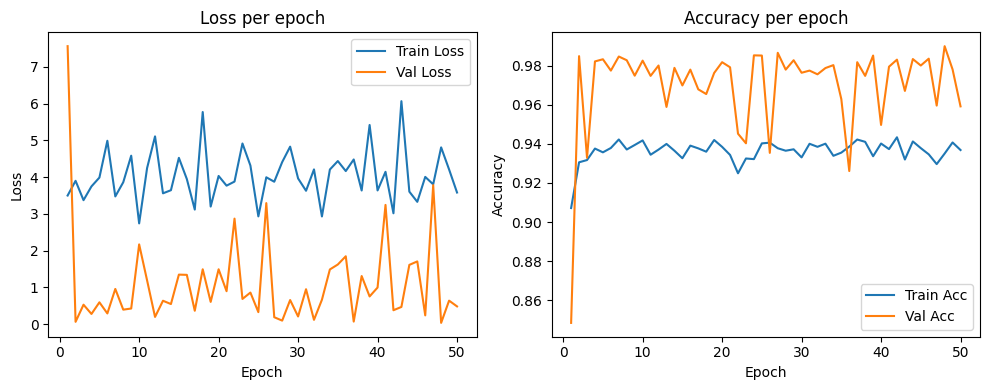

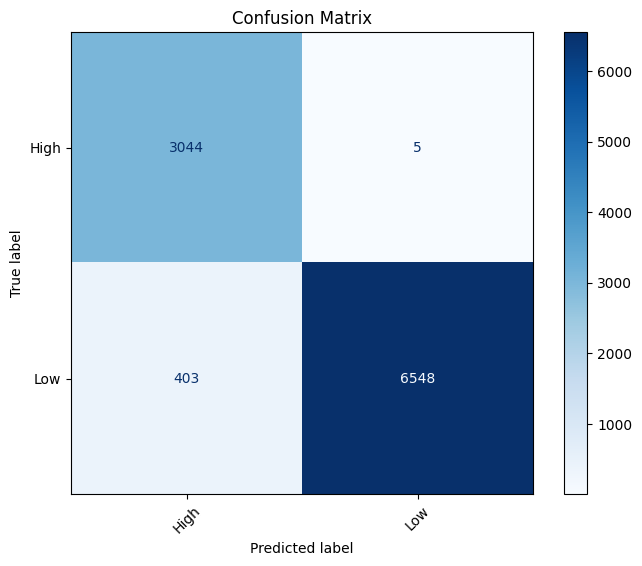

In [ ]:
# EXPERIMENT-3
# Imports & Utilities
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load Data
DATA_PATH = "BMW_DataSet.csv"
df = pd.read_csv(DATA_PATH)

print(df.head())
print(df.info())

TARGET_COL = "Sales_Classification"
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset")

df = df.dropna(subset=[TARGET_COL])

categorical_cols = ["Model", "Region", "Color", "Fuel_Type", "Transmission"]
numeric_cols = ["Year", "Engine_Size_L", "Mileage_KM", "Sales_Volume"]

missing_cols = [c for c in categorical_cols + numeric_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing expected columns in dataset: {missing_cols}")

# Fill numeric NaNs with median
for col in numeric_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Fill categorical NaNs with mode
for col in categorical_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].mode()[0])

# Feature Encoding
# One-hot encode categorical features
X = pd.get_dummies(df.drop(columns=[TARGET_COL]), columns=categorical_cols, drop_first=True)

# Scale all features
scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

# Encode target
y_le = LabelEncoder()
y = y_le.fit_transform(df[TARGET_COL].astype(str))
class_names = list(y_le.classes_)
num_classes = len(class_names)
print("Detected classes:", class_names)

# Train/Test Split
X_train_df, X_test_df, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_np = X_train_df.values.astype(np.float32)
X_test_np = X_test_df.values.astype(np.float32)

# Torch Dataset
class CarDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CarDataset(X_train_np, y_train_np)
test_dataset = CarDataset(X_test_np, y_test_np)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


class CarClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim),
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train_np.shape[1]
hidden_dim = 128
model = CarClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=num_classes, dropout=0.2)
model = model.to(device)
print(model)


# Loss & Optimizer
class_weights = torch.tensor(
    1.0 / np.bincount(y), dtype=torch.float32
).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.5, weight_decay=1e-5) # Further increased learning rate

# Training Loop
NUM_EPOCHS = 50
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(1, NUM_EPOCHS + 1):
    # Training
    model.train()
    running_loss, running_corrects, total_samples = 0.0, 0, 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_X.size(0)
        _, preds = torch.max(outputs, dim=1)
        running_corrects += (preds == batch_y).sum().item()
        total_samples += batch_X.size(0)

    epoch_train_loss = running_loss / total_samples
    epoch_train_acc = running_corrects / total_samples
    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # Validation
    model.eval()
    val_running_loss, val_running_corrects, val_samples = 0.0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            val_running_loss += loss.item() * batch_X.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_running_corrects += (preds == batch_y).sum().item()
            val_samples += batch_X.size(0)

    epoch_val_loss = val_running_loss / val_samples
    epoch_val_acc = val_running_corrects / val_samples
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"train_loss: {epoch_train_loss:.4f} | train_acc: {epoch_train_acc:.4f} | "
          f"val_loss: {epoch_val_loss:.4f} | val_acc: {epoch_val_acc:.4f}")

# Final Evaluation
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

final_acc = accuracy_score(all_targets, all_preds)
print(f"\nFinal Test Accuracy: {final_acc:.4f}")
print("\nClassification report:")
print(classification_report(all_targets, all_preds, target_names=class_names))

# Plots
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accs, label="Train Acc")
plt.plot(range(1, NUM_EPOCHS + 1), val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()